# Import Libraries

In [1]:
import os
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

import matplotlib.pyplot as plt
import random
import copy
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import f1_score, accuracy_score
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
#from efficientnet_pytorch import model as enet

import cv2
import timm

from tqdm import tqdm
from tqdm.notebook import tqdm

import albumentations as A
from albumentations import (
    Compose, OneOf, Normalize, CenterCrop, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, RandomRotate90, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, HueSaturationValue, CoarseDropout,GridDropout
    )
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")

import logging
import time
from contextlib import contextmanager

# Config

In [2]:
class CFG:
    DATA_PATH = '../input/plant-pathology-2021-fgvc8/'
    TEST_PATH = DATA_PATH + 'test_images/'
    TRAIN_PATH = DATA_PATH + 'train_images/'
    TRAIN_CSV_PATH = DATA_PATH + 'train.csv'
    TEST_CSV_PATH = DATA_PATH + 'sample_submission.csv'
    
    #MODEL_ARCH ='vit_base_patch16_224'
    #MODEL_ARCH ='vit_tiny_patch16_224'
    MODEL_ARCH ='vit_base_patch16_224_in21k'

    IMG_SIZE = 224
    EPOCH = 10
    BATCH_SIZE = 32
    TEST_SIZE = 0.2
    RANDOM_STATE = 1234
    LR = 1e-4
    N_CLASS = 12
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    LABELS = ['healthy','complex','rust','frog_eye_leaf_spot','powdery_mildew','scab']
    
    LABELS_DICT = {
    0: 'complex', 
    1: 'frog_eye_leaf_spot',
    2: 'frog_eye_leaf_spot complex',
    3: 'healthy',
    4: 'powdery_mildew', 
    5: 'powdery_mildew complex',
    6: 'rust',
    7: 'rust complex',
    8: 'rust frog_eye_leaf_spot',
    9: 'scab',
    10: 'scab frog_eye_leaf_spot',
    11: 'scab frog_eye_leaf_spot complex'
    }

In [3]:
def to_numpy(tensor):
    """Auxiliary function to convert tensors into numpy arrays
    """
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


# Load Dataframe

In [4]:
train_df = pd.read_csv(CFG.TRAIN_CSV_PATH)
sub_df = pd.read_csv(CFG.TEST_CSV_PATH)

In [5]:
all_vit_models = timm.list_models('*vit*')
all_vit_models

['convit_base',
 'convit_small',
 'convit_tiny',
 'crossvit_9_240',
 'crossvit_9_dagger_240',
 'crossvit_15_240',
 'crossvit_15_dagger_240',
 'crossvit_15_dagger_408',
 'crossvit_18_240',
 'crossvit_18_dagger_240',
 'crossvit_18_dagger_408',
 'crossvit_base_240',
 'crossvit_small_240',
 'crossvit_tiny_240',
 'levit_128',
 'levit_128s',
 'levit_192',
 'levit_256',
 'levit_384',
 'vit_base_patch16_224',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_384',
 'vit_base_patch16_sam_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_384',
 'vit_base_patch32_sam_224',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch16_224',
 'vit_large_patch16_224_in21k',
 'vit_large_patch16_384',
 

# EDA

In [6]:
train_df.head(30)

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
5,800edef467d27c15.jpg,healthy
6,800f85dc5f407aef.jpg,rust
7,801d6dcd96e48ebc.jpg,healthy
8,801f78399a44e7af.jpg,complex
9,8021b94d437eb7d3.jpg,healthy


In [7]:
sub_df

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [8]:
train_df['labels'].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

# Visualize Image

In [9]:
def visualize_batch(path,image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for x, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, x + 1)
        image = cv2.imread(os.path.join(path, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()

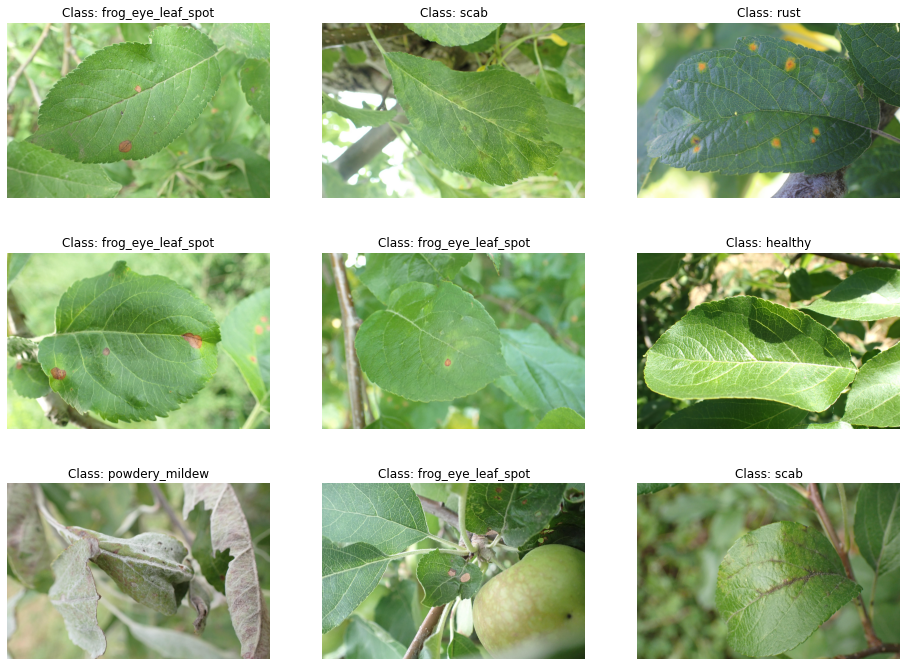

In [10]:
tmp_df = train_df.sample(9)
image_ids = tmp_df["image"].values
labels = tmp_df["labels"].values
visualize_batch(CFG.TRAIN_PATH,image_ids,labels)

# Encode To Unique Label

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(train_df.labels)
train_df['labels'] = le.transform(train_df.labels)

In [12]:
train_df

,image,labels
0,800113bb65efe69e.jpg,3
1,8002cb321f8bfcdf.jpg,11
2,80070f7fb5e2ccaa.jpg,9
3,80077517781fb94f.jpg,9
4,800cbf0ff87721f8.jpg,0
...,...,...
18627,fffb900a92289a33.jpg,3
18628,fffc488fa4c0e80c.jpg,9
18629,fffc94e092a59086.jpg,6
18630,fffe105cf6808292.jpg,10


In [13]:
train_df['labels']==2

0        False
1        False
2        False
3        False
4        False
         ...  
18627    False
18628    False
18629    False
18630    False
18631    False
Name: labels, Length: 18632, dtype: bool

# Seed

In [14]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

@contextmanager
def timer(name, logger=None, level=logging.DEBUG):
    print_ = print if logger is None else lambda msg: logger.log(level, msg)
    t0 = time.time()
    print_(f'[{name}] start')
    yield
    print_(f'[{name}] done in {time.time() - t0:.0f} s')

# Debug

In [15]:
DEBUG = False
if DEBUG:
    train_df= train_df.sample(frac = 0.05).reset_index(drop = True)
    print(train_df.shape)

# Split Data

In [16]:
from sklearn.model_selection import train_test_split
train, valid =  train_test_split(train_df, test_size = 0.2)
print(train.shape, valid.shape)

(14905, 2) (3727, 2)


In [17]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

train_targets = train.labels.values
valid_targets = valid.labels.values

In [18]:
train

,image,labels
0,f73e8383b80bb438.jpg,0
1,dc03c874323cf3cd.jpg,4
2,f8b371039bcc26e4.jpg,10
3,e575df8035023b47.jpg,9
4,98b875c816b5f45a.jpg,9
...,...,...
14900,fad00fe6609bc3c1.jpg,0
14901,f52ee9b296cb6005.jpg,9
14902,afe416a0896fc19d.jpg,3
14903,8f512dd7711c8aa9.jpg,3


In [19]:
valid

,image,labels
0,cff833939a8b02e2.jpg,0
1,e55dd66bb4209992.jpg,9
2,a42787f4291dd971.jpg,6
3,f3ed97cd4aa09111.jpg,3
4,a5b5d54a4b1e1e34.jpg,9
...,...,...
3722,f95c31e8bde0dc20.jpg,6
3723,c0833bfd3c7c2839.jpg,9
3724,f9a7c81249bd14e5.jpg,6
3725,a5d1d2d0ce1aeb61.jpg,3


# Dataset

In [20]:
#pytorchのDatasetクラスを継承したクラスを作成する
class TrainDataset(Dataset):
    def __init__(self, df, transform = None): #初期化
        self.df = df
        self.image_names = df["image"].values
        self.labels = df["labels"].values
        self.transform = transform
        
#データの長さを返す関数
    def __len__(self):
        return len(self.df)
    
#indexに対応する画像とラベルを返す関数
    def __getitem__(self, idx):
        image_name = self.image_names[idx] #indexに対応するimageの値
        image_path = CFG.TRAIN_PATH + image_name #indexに対応するデータのパス
        image = cv2.imread(image_path) #画像読み込み
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #BGR→RGB
        label = self.labels[idx] #indexに対応するラベル
        #label = torch.tensor(self.labels[idx]).float()
        if self.transform: #前処理ある場合
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

# Augmentation 

In [21]:
def get_transforms(data):
    
    if data == 'train':
        return Compose([
            A.Resize(CFG.IMG_SIZE, CFG.IMG_SIZE),
            A.Rotate(limit=45, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.GridDropout(ratio=0.3, unit_size_min=None, unit_size_max=None, holes_number_x=5, holes_number_y=5, shift_x=0, shift_y=0, random_offset=False, fill_value=0, mask_fill_value=None, always_apply=False, p=0.5),
            #A.ShiftScaleRotate(p=0.5),
            A.Normalize(),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return Compose([
            Resize(CFG.IMG_SIZE, CFG.IMG_SIZE),
            Normalize(),
            ToTensorV2(),
        ])

In [22]:
# 上で作成したデータセットクラスを呼び出す
train_dataset = TrainDataset(train, transform = get_transforms(data = 'train'))
# データセットクラスによって取り出されるデータをbatch数でまとめる
train_loader = DataLoader(train_dataset, CFG.BATCH_SIZE, shuffle = True,drop_last = True, num_workers=2)

In [23]:
train_dataset[0]

(tensor([[[ 0.9646,  0.9988,  1.0502,  ...,  0.2282,  0.4508,  0.3652],
          [ 1.0331,  1.0159,  1.0844,  ...,  0.2453,  0.2967,  0.2967],
          [ 0.9817,  0.9988,  1.1015,  ...,  0.1939,  0.1083,  0.1426],
          ...,
          [ 1.4612,  1.3242,  1.4269,  ...,  0.9132,  1.0502,  1.3242],
          [ 1.5297,  1.4783,  1.4783,  ...,  1.0502,  1.1529,  1.3755],
          [ 1.4954,  1.4954,  1.5125,  ...,  1.1358,  1.2214,  1.4612]],
 
         [[ 1.5882,  1.6232,  1.7283,  ...,  1.2731,  1.4482,  1.3606],
          [ 1.6758,  1.6758,  1.7808,  ...,  1.2556,  1.2906,  1.3256],
          [ 1.6232,  1.6583,  1.7808,  ...,  1.2556,  1.1681,  1.2031],
          ...,
          [ 2.2010,  2.0259,  2.1134,  ...,  1.8859,  1.8333,  1.9384],
          [ 2.2360,  2.1660,  2.1660,  ...,  2.0434,  1.9559,  1.9559],
          [ 2.1835,  2.1660,  2.2010,  ...,  2.1660,  2.0084,  1.9909]],
 
         [[ 1.2282,  1.2457,  1.2980,  ..., -0.0267,  0.1999,  0.1302],
          [ 1.2980,  1.2805,

In [24]:
valid_dataset = TrainDataset(valid, transform = get_transforms(data = 'valid'))
valid_loader = DataLoader(valid_dataset, CFG.BATCH_SIZE, shuffle = False, num_workers=2)

In [25]:
valid_dataset[0]

(tensor([[[ 1.4440,  1.4269,  1.4783,  ...,  1.1700,  1.0673,  1.0159],
          [ 1.4954,  1.4612,  1.5125,  ...,  1.2214,  1.1700,  1.0331],
          [ 1.5810,  1.5297,  1.5125,  ...,  1.1872,  1.1872,  1.1015],
          ...,
          [ 0.8618,  1.0159,  0.9646,  ..., -0.7308, -0.9363, -0.8164],
          [ 0.9303,  0.9646,  0.9303,  ..., -0.7993, -0.8507, -0.7993],
          [ 0.9132,  0.9988,  0.7248,  ..., -0.8507, -0.8507, -0.8164]],
 
         [[ 1.7983,  1.7983,  1.8508,  ...,  1.6758,  1.6057,  1.4832],
          [ 1.8859,  1.8158,  1.8683,  ...,  1.6933,  1.6933,  1.5532],
          [ 1.9734,  1.8859,  1.8683,  ...,  1.6583,  1.7108,  1.6232],
          ...,
          [ 1.3431,  1.4482,  1.3606,  ..., -0.1800, -0.3725, -0.2675],
          [ 1.4132,  1.3957,  1.3256,  ..., -0.2500, -0.3025, -0.2325],
          [ 1.3782,  1.4307,  1.1506,  ..., -0.3025, -0.3025, -0.2850]],
 
         [[ 1.2631,  1.2108,  1.2631,  ...,  1.2457,  1.1585,  1.0714],
          [ 1.3502,  1.2805,

# Create Model

In [26]:
class ViT(nn.Module):
    """
        Base class for all neural network modules.
        Your models should also subclass this class.
        Modules can also contain other Modules, allowing to nest them in a tree structure.
        You can assign the submodules as regular attributes:
    """
    def __init__(self):
        super(ViT, self).__init__()
        self.vit = timm.create_model(model_name = CFG.MODEL_ARCH,pretrained = True)
        
        #in_features = self.vit.fc.in_features
        #self.efficientnetb2.classifier = nn.Linear(in_features, len(CFG.LABELS))#(input_size,output_size)
        self.vit.head = nn.Linear(self.vit.head.in_features, CFG.N_CLASS)

#         self.model.fc = nn.Linear(in_features, CFG.num_classes)
    def forward(self, x):
        x = self.vit(x)
        return x
    
model = ViT()

#print(in_features)

In [27]:
!pip install torchsummary

# Training

plot_train_loss = [1.7224,1.5678,1.5014,1.4602,1.4050,1.3466,1.2910,1.2284,1.1901,1.1609]
plot_train_acc = [0.3478,0.4147,0.4372,0.4519,0.4800,0.5067,0.5339,0.5631,0.5797,0.5899]
plot_train_f1 = [0.2175,0.2892,0.3124,0.3285,0.3545,0.3806,0.4005,0.4360,0.4423,0.4555]

plot_valid_loss = [1.6821,1.4957,1.4961,1.4552,1.3838,1.3707,1.3180,1.2486,1.2151,1.1983]
plot_valid_acc = [0.3396,0.4358,0.4628,0.4524,0.4906,0.4992,0.5355,0.5561,0.5794,0.5906]
plot_valid_f1 = [0.1735,0.3201,0.3250,0.3153,0.3672,0.3823,0.4111,0.4286,0.4337,0.4453]

# Checkpoint

In [28]:
def save_checkpoint(state, filename='my_checkpoint.pt'):
    print('==> Saving checkpoint')
    torch.save(state, filename)
    
def load_checkpoint(checkpoint):
    print('==> Loading checkpoint')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    num_epochs = checkpoint['num_epochs']

#model.eval()
# - or -
#model.train()

In [29]:
plot_train_loss = []
plot_train_acc = []
plot_train_f1 = []

plot_valid_loss = []
plot_valid_acc = []
plot_valid_f1 = []

In [30]:
def train_model(datasets, dataloaders, model, criterion, optimizer, num_epochs, device):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_acc = 0.0
            running_f1 = 0.0
            
            load_model = False

            if load_model and epoch==0:
                model = ViT()
                load_checkpoint(torch.load('../input/checkpoint/my_checkpoint (1).pt'))
                #model = model.to(CFG.DEVICE)
            
            if epoch % 3 == 0 and epoch != 0:
                checkpoint = {'model_state_dict': model.state_dict(),
                              'optimizer_state_dict': optimizer.state_dict(),
                              'num_epochs': epoch}
                save_checkpoint(checkpoint)
            
            stream = tqdm(dataloaders[phase])
            for batch ,(inputs, labels) in enumerate(stream, start=1):
                inputs = inputs.to(CFG.DEVICE)
                labels = labels.to(CFG.DEVICE)
               
                # Zero out the grads
                optimizer.zero_grad()
                
                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(CFG.DEVICE)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                #print(loss, loss.item())
                # Statistics input_size(0)=32 .item()はキーとバリューを取得
                running_loss += loss.item()
                running_acc += accuracy_score(to_numpy(preds), to_numpy(labels), normalize=True)
                #running_corrects += torch.sum(preds == labels.data)
                running_f1 += f1_score(to_numpy(preds), to_numpy(labels), average='macro')
                #print(inputs.size(0), running_loss)
            
            #if phase == 'train':
                #scheduler.step()
                
            epoch_loss = running_loss / batch
            epoch_acc = running_acc / batch
            epoch_f1 = running_f1/batch
            
            if phase == 'train':
                plot_train_loss.append(epoch_loss)
                plot_train_acc.append(epoch_acc)
                plot_train_f1.append(epoch_f1)
            else:
                plot_valid_loss.append(epoch_loss)
                plot_valid_acc.append(epoch_acc)
                plot_valid_f1.append(epoch_f1)
            
            
            print('{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1))
            
            if phase == 'valid' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val F1: {:.4f}'.format(best_f1))
    
    model.load_state_dict(best_model_wts)
    
    return model

In [31]:
datasets = {'train': train_dataset,
            'valid': valid_dataset}

dataloaders = {'train': train_loader,
               'valid': valid_loader}
optimizer = optim.SGD(model.parameters(),lr=0.0001,momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [32]:
trained_model = train_model(datasets, dataloaders, model, criterion, optimizer, CFG.EPOCH, CFG.DEVICE)

Epoch 1/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.7193 Acc: 0.7788 F1: 0.5943


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.4635 Acc: 0.8579 F1: 0.6617

Epoch 2/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.4447 Acc: 0.8582 F1: 0.6750


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.3676 Acc: 0.8854 F1: 0.7115

Epoch 3/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.3734 Acc: 0.8794 F1: 0.7116


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.3601 Acc: 0.8889 F1: 0.7294

Epoch 4/10
----------
==> Saving checkpoint


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.3291 Acc: 0.8931 F1: 0.7321
==> Saving checkpoint


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.3268 Acc: 0.8934 F1: 0.7242

Epoch 5/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.2983 Acc: 0.9003 F1: 0.7467


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.3259 Acc: 0.8971 F1: 0.7391

Epoch 6/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.2789 Acc: 0.9078 F1: 0.7608


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.3184 Acc: 0.8982 F1: 0.7179

Epoch 7/10
----------
==> Saving checkpoint


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.2400 Acc: 0.9194 F1: 0.7848
==> Saving checkpoint


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.3204 Acc: 0.8985 F1: 0.7347

Epoch 8/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.2318 Acc: 0.9214 F1: 0.7917


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.3086 Acc: 0.9057 F1: 0.7413

Epoch 9/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.2015 Acc: 0.9320 F1: 0.8159


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.3115 Acc: 0.9014 F1: 0.7352

Epoch 10/10
----------
==> Saving checkpoint


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.1863 Acc: 0.9365 F1: 0.8274
==> Saving checkpoint


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.3328 Acc: 0.8937 F1: 0.7299

Training complete in 325m 1s
Best val F1: 0.7413


# Save Model

In [33]:
model_path = 'vit_tiny.pth'
#model_path = 'vit_model.pt'
#torch.save(model.state_dict(), model_path)

In [34]:
#state = {'model': model.state_dict(),}
#torch.save(state, model_path)
torch.save(model.state_dict(), model_path)

In [35]:
for key, param in model.state_dict().items():
    print(key, "\t", param.size())

vit.cls_token 	 torch.Size([1, 1, 768])
vit.pos_embed 	 torch.Size([1, 197, 768])
vit.patch_embed.proj.weight 	 torch.Size([768, 3, 16, 16])
vit.patch_embed.proj.bias 	 torch.Size([768])
vit.blocks.0.norm1.weight 	 torch.Size([768])
vit.blocks.0.norm1.bias 	 torch.Size([768])
vit.blocks.0.attn.qkv.weight 	 torch.Size([2304, 768])
vit.blocks.0.attn.qkv.bias 	 torch.Size([2304])
vit.blocks.0.attn.proj.weight 	 torch.Size([768, 768])
vit.blocks.0.attn.proj.bias 	 torch.Size([768])
vit.blocks.0.norm2.weight 	 torch.Size([768])
vit.blocks.0.norm2.bias 	 torch.Size([768])
vit.blocks.0.mlp.fc1.weight 	 torch.Size([3072, 768])
vit.blocks.0.mlp.fc1.bias 	 torch.Size([3072])
vit.blocks.0.mlp.fc2.weight 	 torch.Size([768, 3072])
vit.blocks.0.mlp.fc2.bias 	 torch.Size([768])
vit.blocks.1.norm1.weight 	 torch.Size([768])
vit.blocks.1.norm1.bias 	 torch.Size([768])
vit.blocks.1.attn.qkv.weight 	 torch.Size([2304, 768])
vit.blocks.1.attn.qkv.bias 	 torch.Size([2304])
vit.blocks.1.attn.proj.weight 	 t

In [36]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 2304]       1,771,776
           Dropout-7         [-1, 12, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
           Dropout-9             [-1, 197, 768]               0
        Attention-10             [-1, 197, 768]               0
         Identity-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 3072]       2,362,368
             GELU-14            [-1, 19

In [37]:
plot_valid_loss,plot_valid_acc,plot_valid_f1

([0.46350453475601655,
  0.3676013521149627,
  0.3601097188507899,
  0.32676129476127463,
  0.3259170883231693,
  0.3184388364291089,
  0.3203872625007589,
  0.3085719518618196,
  0.3115451533633929,
  0.33277535648682177],
 [0.8578703703703704,
  0.8853810541310542,
  0.8888532763532764,
  0.8933938746438747,
  0.8971331908831909,
  0.8982015669515669,
  0.898468660968661,
  0.9056801994301995,
  0.9014066951566951,
  0.8936609686609687],
 [0.6616929119506222,
  0.7115446242469897,
  0.7294114981831964,
  0.7241514427594371,
  0.7390668169658055,
  0.7179339517089575,
  0.7346879524673413,
  0.7412950031623263,
  0.7352439289022302,
  0.7299479737319345])

# Visualization 

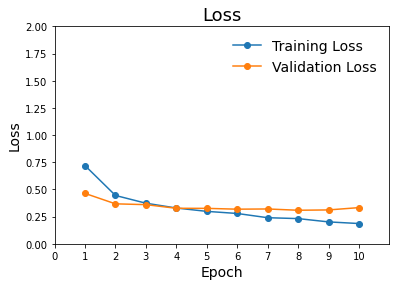

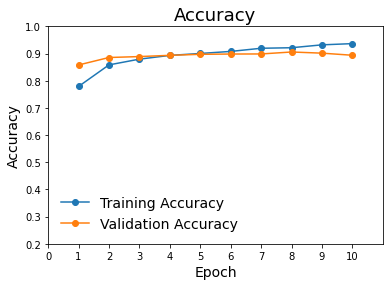

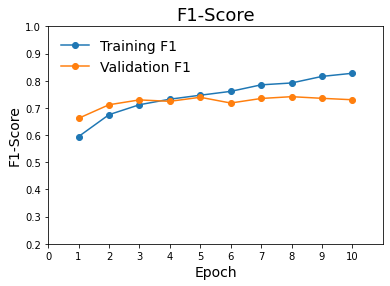

In [38]:
import matplotlib.pyplot as plt

#loss
plt.title("Loss",fontsize=18)
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("Loss",fontsize=14)

plt.ylim(0, 2.0)
plt.xlim(0, 11, 1)

plt.xticks(np.arange(0, 11, 1))
plt.plot(range(1, 11),plot_train_loss,label='Training Loss',marker ='o')
plt.plot(range(1, 11),plot_valid_loss,label='Validation Loss',marker ='o')
plt.legend(frameon=False, fontsize=14)

plt.show()

#acc
plt.title("Accuracy",fontsize=18)
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)

plt.ylim(0.2, 1.0)
plt.xlim(0, 11, 1)

plt.xticks(np.arange(0, 11, 1))
plt.plot(range(1, 11),plot_train_acc,label='Training Accuracy',marker ='o')
plt.plot(range(1, 11),plot_valid_acc,label='Validation Accuracy',marker ='o')
plt.legend(frameon=False, fontsize=14)

plt.show()

#f1
plt.title("F1-Score",fontsize=18)
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("F1-Score",fontsize=14)

plt.ylim(0.2, 1.0)
plt.xlim(0, 11, 1)

plt.xticks(np.arange(0, 11, 1))
plt.plot(range(1, 11),plot_train_f1,label='Training F1',marker ='o')
plt.plot(range(1, 11),plot_valid_f1,label='Validation F1',marker ='o')
plt.legend(frameon=False, fontsize=14)

plt.show()